In [1]:
from    tqdm.notebook   import  tqdm
import  matplotlib.pyplot   as  plt

import  torch
from    pathlib         import  Path
path_root = Path(r"/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE")
path_lib  = path_root / "python_deep_numerical"
from    sys     import  path
path.append(str(path_lib))
from    pytorch.torch_numerical     import utils, distribution
from    pytorch.layers              import FourierLandauLayer


dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
specnet = FourierLandauLayer(2, 8)
specnet.load_state_dict(torch.load(r"/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE/datasets/Landau__alpha_0__res_64__specnet__deg_8.pth", weights_only=False))
specnet = specnet.to(device)
specnet.eval()

FourierLandauLayer()

In [3]:
arr_t = torch.linspace(0, 1, 5001, device=device, dtype=dtype)
delta_t = float((arr_t[1]-arr_t[0]).cpu())
arr_v = utils.velocity_grid(2, 128, 3/utils.LAMBDA, device=device, dtype=dtype)
bkw_sol = distribution.bkw(arr_t, arr_v, 1.0, 0.5, equation='fpl')
bkw_init = bkw_sol[:, 0]
print(bkw_init.shape)

----------[ BKW solution ]----------
* coeff_ext: 0.5
* coeff_int: 2.0
------------------------------------
torch.Size([1, 1, 1, 128, 128, 1])


In [4]:
arr_f = bkw_init
arr_f_fft = torch.fft.fftn(arr_f, dim=(-3,-2), norm='forward')

# k1  = derivative(t_curr, y_curr)
# k2  = derivative(t_curr + (2/3)*delta_t, y_curr + (2/3)*delta_t*k1)
# return y_curr + delta_t * (k1 + 3*k2) / 4

arr_distribution: list[torch.Tensor] = [arr_f.cpu()]
for t_next in tqdm(arr_t[1:]):
    k1 = specnet.forward(arr_f_fft)
    k2 = specnet.forward(arr_f_fft + (2/3)*delta_t*k1)
    arr_f_fft = arr_f_fft + delta_t * (k1+3*k2)/4
    arr_f = torch.fft.ifftn(arr_f_fft, dim=(-3,-2), norm='forward').real
    arr_distribution.append(arr_f.cpu())
    del(k1, k2)

arr_distribution = torch.stack(arr_distribution, dim=1)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
rel_error = utils.relative_error(arr_distribution[0], bkw_sol.cpu()[0])
print(rel_error.shape)

torch.Size([5001])


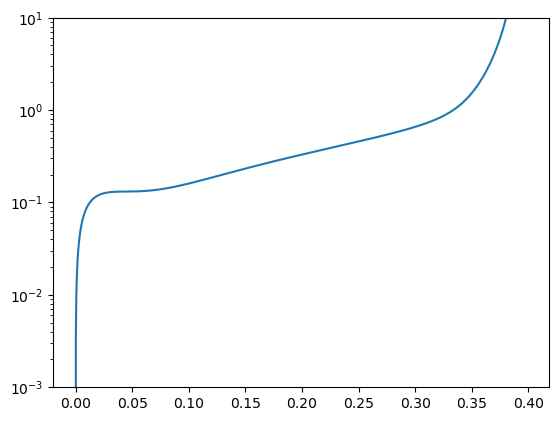

In [8]:
plt.plot(arr_t.cpu(), rel_error.detach().cpu())
# plt.xlim((0,0.3))
plt.ylim((1e-3, 1e+1))
plt.yscale('log')
plt.show()